## Fetch the MNIST Dataset

In [1]:
import pickle

# from sklearn.datasets import fetch_openml
# mnist = fetch_openml("mnist_784", version=1)

# # save it to a python file
# with open("mnist_data.pkl", "wb") as f:
#     pickle.dump(mnist, f)

## Load MNIST

In [2]:
# read the mnist data
with open("mnist_data.pkl", "rb") as f:
    mnist = pickle.load(f)
    
print(mnist.keys())
X, y = mnist["data"], mnist["target"]
X.shape

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])


(70000, 784)

In [3]:
y.shape

(70000,)

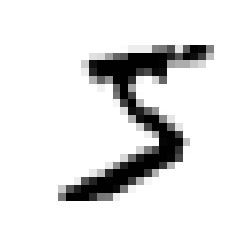

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
# label of the image above
y[0]

'5'

In [7]:
import numpy as np

# cast labels to integers
y = y.astype(np.uint8)
y[0]

5

In [8]:
# create train and test sets (mnist is already splitted as 60000:10000)
# no need to shuffle as mnist data is already shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Train a binary classifier

In [9]:
# true for all 5s, false for others
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
# in an ideal world result would be like this
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and recall

##### Precision: It's correct only %83 (precision) of the time.
##### Recall: It detects only %65 (recall) of the items.

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
from sklearn.metrics import f1_score

# harmonic mean, combining precision and recall
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Decision function (threshold) and precision/recall tradeoff

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
# return decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

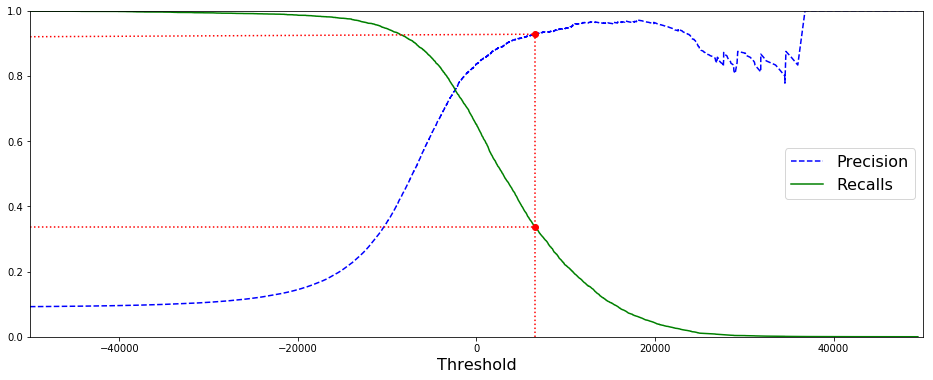

In [64]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center right", fontsize=16)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(16, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([6551, 6551], [0., 0.9277], "r:")
plt.plot([-50000, 6551], [0.92, 0.9277], "r:")
plt.plot([-50000, 6551], [0.3364, 0.3364], "r:")
plt.plot([6551], [0.9277], "ro")
plt.plot([6551], [0.3364], "ro")
plt.show()

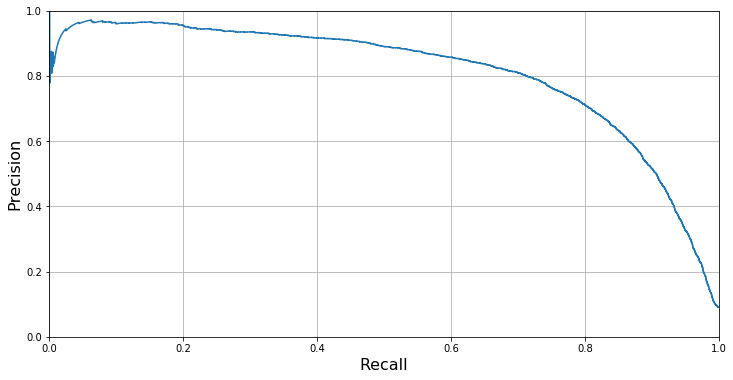

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(recalls, precisions)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)

In [75]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [76]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [77]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [78]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC curve

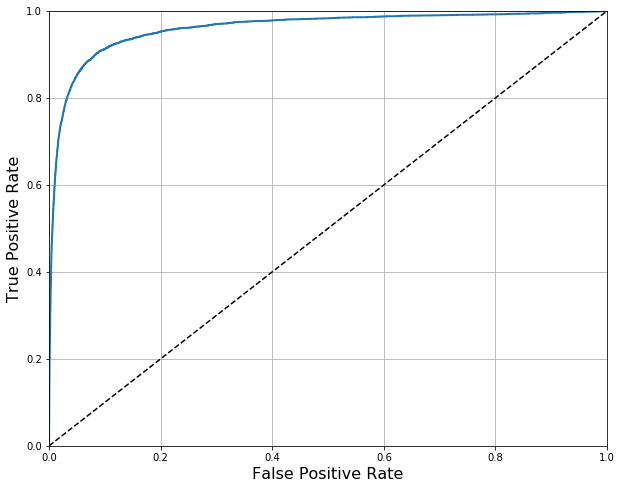

In [82]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(10, 8))
plot_roc_curve(fpr, tpr)
plt.show()

In [83]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [87]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# get the probas of positive class
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


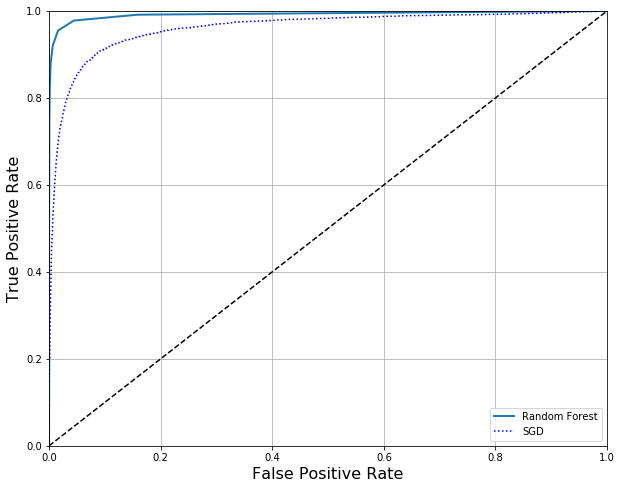

In [92]:
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
plt.show()

In [93]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [94]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.986046511627907

In [95]:
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889

## Multiclass classification

In [96]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [97]:
# let's see how many binary classifiers were trained with OvA (one-versus-all) method
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [98]:
np.argmax(some_digit_scores)

3

In [99]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [100]:
sgd_clf.classes_[3]

3

### Forcing scikit-learn to use OvO (one-versus-one)

In [101]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [102]:
len(ovo_clf.estimators_)

45

In [103]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [104]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [105]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [106]:
from sklearn.preprocessing import StandardScaler

# scaling the inputs increases accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

## Error analysis

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

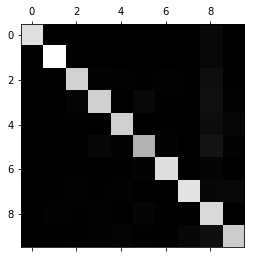

In [115]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

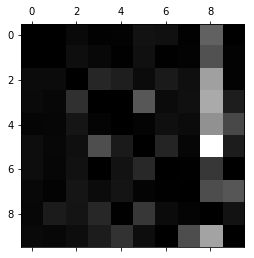

In [127]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel classification

In [221]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [222]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9671989524961443

In [227]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

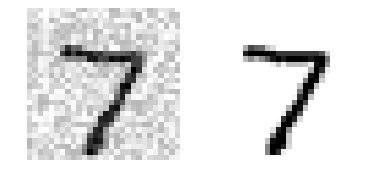

In [228]:
import os

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

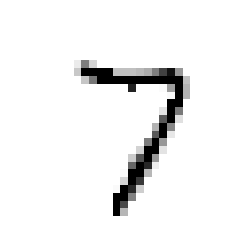

In [229]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

### 1) Trying to build a classifier with over %97 accuracy on test set

In [232]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, cv=3)

array([0.96760648, 0.96704835, 0.96754513])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        "n_neighbors": [2, 3, 4, 5, 6, 7, 8],
        "weights": ["uniform", "distance"]
    }
]

knn_gridsearch = GridSearchCV(knn, param_grid, scoring="accuracy", cv=3,
                              return_train_score=True)
knn_gridsearch.fit(X_train, y_train)

In [ ]:
knn_gridsearch.best_params_

In [ ]:
knn_gridsearch.best_estimator_

In [ ]:
knn_gridsearch.cv_results_

In [160]:
import os

hams = []

for f in os.listdir("easy_ham"):
    with open(os.path.join("easy_ham", f), encoding="utf-8", errors="ignore") as ham:
        hams.append(ham.read())
        
print(len(hams))

import os

spams = []

for f in os.listdir("spam"):
    with open(os.path.join("spam", f), encoding="utf-8", errors="ignore") as spam:
        spams.append(spam.read())
        
print(len(spams))

2551
501


In [161]:
import pandas as pd
import numpy as np

a = pd.DataFrame(spams, columns=["mail"])
a["label"] = 1

b = pd.DataFrame(hams, columns=["mail"])
b["label"] = 0

mails = pd.concat([a, b], ignore_index=True)
mails

,mail,label
0,From marcie1136786@yahoo.com Tue Aug 27 18:49...,1
1,From OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM...,1
2,From home_loans@eudoramail.com Tue Sep 24 10:...,1
3,From ra1pohk6x5119@yahoo.com Mon Aug 26 15:14...,1
4,From r13960@forum.dk Mon Sep 2 12:19:53 2002...,1
5,From cweqx@dracnet.es Mon Aug 26 15:14:56 200...,1
6,From ilug-admin@linux.ie Thu Aug 29 14:24:30 ...,1
7,From safety33o@l11.newnamedns.com Fri Aug 23 ...,1
8,From jamie@msn.com Tue Aug 27 14:27:25 2002\n...,1
9,From ilug-admin@linux.ie Thu Sep 26 11:30:33 ...,1


In [162]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(mails["mail"], mails["label"], test_size=0.2)

In [163]:
from sklearn.model_selection import cross_val_score

In [187]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = mails["mail"].values


vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

['00', '000', '0000', '00000', '000000', '000000000', '000000000000000000000', '00000053', '0000006f', '00000073', '00000094', '000000c958bd', '00000108', '0000015d', '000001c249ff', '000001c259c0', '000001c266a5', '000001c26e44', '00000254', '000002d3', '000003d2', '0000047b4e66', '000004fe', '00000530', '00000582', '0000059b', '000005d0', '000006f0', '000007070213', '00000709', '000007e2', '000007f6', '0000082a', '000008aa', '00000908', '00000b1a', '00000b1d6a3c', '00000b41', '00000c1e285f', '00000c87', '00000c981b9d', '00000e7a', '00001', '00001008', '0000107a309a', '000010db', '000010fb', '0000120c087e', '00001240', '00001258', '0000125d', '000012c8', '00001317', '0000133b', '000013ca', '00001431', '0000145a', '00001503', '00001631', '000016c5', '00001798', '000018', '00001889', '000019342305', '0000195e74e5', '000019d21bce', '00001aaa', '00001ab3560f', '00001b86', '00001c54', '00001cd1', '00001d407f75', '00001e44', '00002', '000022f1', '0000234d', '000023b8700d', '000023be', '0000

[[2 0 2 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [5 0 4 ... 0 0 0]]


In [164]:
import nltk
from nltk.tokenize import word_tokenize

In [165]:
mails["mail"][0]

'From marcie1136786@yahoo.com  Tue Aug 27 18:49:30 2002\nReturn-Path: <marcie1136786@yahoo.com>\nDelivered-To: zzzz@localhost.example.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.example.com (Postfix) with ESMTP id 410B343F99\n\tfor <zzzz@localhost>; Tue, 27 Aug 2002 13:49:30 -0400 (EDT)\nReceived: from mail.webnote.net [193.120.211.219]\n\tby localhost with POP3 (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Tue, 27 Aug 2002 18:49:30 +0100 (IST)\nReceived: from info.chinacoal.gov.cn ([211.99.74.5])\n\tby webnote.net (8.9.3/8.9.3) with ESMTP id SAA00397\n\tfor <zzzz@example.com>; Tue, 27 Aug 2002 18:42:17 +0100\nFrom: marcie1136786@yahoo.com\nMessage-Id: <200208271742.SAA00397@webnote.net>\nReceived: from 211.97.147.11 ([211.97.147.11]) by info.chinacoal.gov.cn with SMTP (Microsoft Exchange Internet Mail Service Version 5.5.2653.13)\n\tid RPBL0WFB; Sat, 24 Aug 2002 01:06:46 +0800\nTo: zzzz@brooksresources.com, jm@cheetah.net, jm@colorado.net,\n\tzzzz@

In [166]:
import unicodedata
from nltk.corpus import stopwords

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [167]:
mails1

,mail,label


In [178]:
mails1 = pd.DataFrame(columns=mails.columns)

In [179]:
for idx, row in mails.iterrows():
    mails1 = mails1.append({"mail": normalize(word_tokenize(row["mail"])), "label": row["label"]}, ignore_index=True)


In [122]:
normalize(word_tokenize(mails["mail"][0]))

['marcie1136786',
 'yahoocom',
 'tue',
 'aug',
 '27',
 '184930',
 '2002',
 'returnpath',
 'marcie1136786',
 'yahoocom',
 'deliveredto',
 'zzzz',
 'localhostexamplecom',
 'received',
 'localhost',
 'localhost',
 '127001',
 'phoboslabsexamplecom',
 'postfix',
 'esmtp',
 'id',
 '410b343f99',
 'zzzz',
 'localhost',
 'tue',
 '27',
 'aug',
 '2002',
 '134930',
 '0400',
 'edt',
 'received',
 'mailwebnotenet',
 '193120211219',
 'localhost',
 'pop3',
 'fetchmail590',
 'zzzz',
 'localhost',
 'singledrop',
 'tue',
 '27',
 'aug',
 '2002',
 '184930',
 '0100',
 'ist',
 'received',
 'infochinacoalgovcn',
 '21199745',
 'webnotenet',
 '893893',
 'esmtp',
 'id',
 'saa00397',
 'zzzz',
 'examplecom',
 'tue',
 '27',
 'aug',
 '2002',
 '184217',
 '0100',
 'marcie1136786',
 'yahoocom',
 'messageid',
 '200208271742saa00397',
 'webnotenet',
 'received',
 '2119714711',
 '2119714711',
 'infochinacoalgovcn',
 'smtp',
 'microsoft',
 'exchange',
 'internet',
 'mail',
 'service',
 'version',
 '55265313',
 'id',
 'rpbl